In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from collections import Counter
import hashlib
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from scipy.stats import pearsonr
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import string
from tqdm import tqdm
from scipy.sparse import hstack
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, auc, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alenp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alenp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alenp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\alenp\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
mv = pd.read_csv(r"D:\Work\Internshala\NLP\Imdb - data_imdb.csv")

In [3]:
mv.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
print(mv['review'])

0        One of the other reviewers has mentioned that ...
1        A wonderful little production. <br /><br />The...
2        I thought this was a wonderful way to spend ti...
3        Basically there's a family where a little boy ...
4        Petter Mattei's "Love in the Time of Money" is...
                               ...                        
49995    I thought this movie did a down right good job...
49996    Bad plot, bad dialogue, bad acting, idiotic di...
49997    I am a Catholic taught in parochial elementary...
49998    I'm going to have to disagree with the previou...
49999    No one expects the Star Trek movies to be high...
Name: review, Length: 50000, dtype: object


# Data Exploration and Preprocessing

In [6]:
mv.isnull().sum()

review       0
sentiment    0
dtype: int64

In [7]:
mv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [8]:
mv.duplicated().sum()

419

In [9]:
def text_hash(text):
    return hashlib.md5(text.encode()).hexdigest()

# Add hash column
mv['txt_hash'] = mv['review'].apply(text_hash)

# Now check duplicates on the hash (much more efficient)
hash_duplicates = mv.duplicated(subset=['txt_hash'])
print("Duplicate hashes:", mv[hash_duplicates])

Duplicate hashes:                                                   review sentiment  \
3537   Quite what the producers of this appalling ada...  negative   
3769   My favourite police series of all time turns t...  positive   
4391   Beautiful film, pure Cassavetes style. Gena Ro...  positive   
6352   If you liked the Grinch movie... go watch that...  negative   
6479   I want very much to believe that the above quo...  negative   
...                                                  ...       ...   
49912  This is an incredible piece of drama and power...  positive   
49950  This was a very brief episode that appeared in...  negative   
49984  Hello it is I Derrick Cannon and I welcome you...  negative   
49986  This movie is a disgrace to the Major League F...  negative   
49991  Les Visiteurs, the first movie about the medie...  negative   

                               txt_hash  
3537   d24f72304cbda6bf9cdb43e089d7657b  
3769   779131fd4709307319f714b36f97ad41  
4391   87b7444c

In [10]:
mv.drop_duplicates(inplace=True)

In [11]:
mv.drop(['txt_hash'], axis=1, inplace=True)

In [12]:
mv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49581 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     49581 non-null  object
 1   sentiment  49581 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [13]:
vc = mv['sentiment'].value_counts()
print(vc)

sentiment
positive    24884
negative    24697
Name: count, dtype: int64


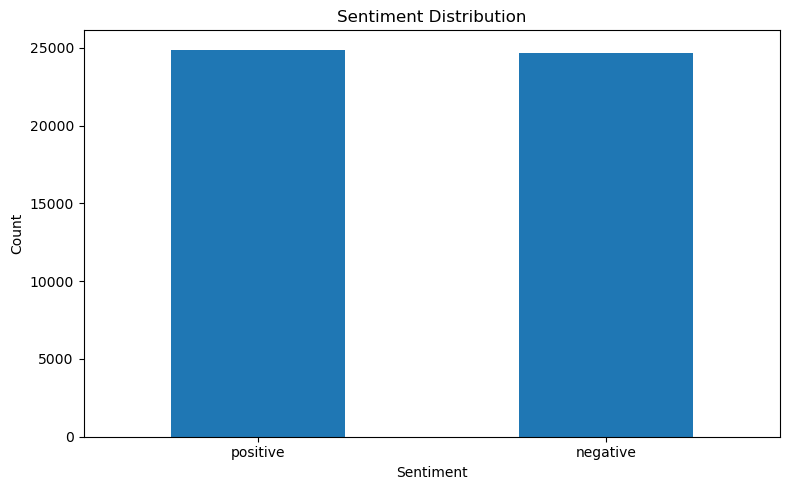

In [14]:
plt.figure(figsize=(8, 5))
vc.plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [21]:
class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
        self.punctuation = set(string.punctuation)
        
    def clean_text(self, text):
        """Remove HTML tags, special characters, and normalize text"""
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        
        # Remove hyphens with white space
        text = re.sub(r'(\w)-(\w)', r'\1 \2', text)
        
        # Remove special characters and numbers, keep only letters
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove extra whitespace
        text = ' '.join(text.split())
        
        return text
    
    def tokenize_text(self, text):
        """Split text into individual words (tokens)"""
        return word_tokenize(text)
    
    def remove_stopwords(self, tokens):
        """Remove common stop words"""
        return [token for token in tokens if token not in self.stop_words]
    
    def apply_stemming(self, tokens):
        """Apply Porter stemming to reduce words to their root form"""
        return [self.stemmer.stem(token) for token in tokens]
    
    def apply_lemmatization(self, tokens):
        """Apply lemmatization to reduce words to their dictionary form"""
        return [self.lemmatizer.lemmatize(token) for token in tokens]
    
    def preprocess_pipeline(self, text, use_stemming=True, use_lemmatization=True):
        """Complete preprocessing pipeline"""
        # Step 1: Clean text
        cleaned_text = self.clean_text(text)
        
        # Step 2: Tokenize
        tokens = self.tokenize_text(cleaned_text)
        
        # Step 3: Remove stopwords
        tokens = self.remove_stopwords(tokens)
        
        # Step 4: Apply stemming and/or lemmatization
        if use_stemming:
            tokens = self.apply_stemming(tokens)
        if use_lemmatization:
            tokens = self.apply_lemmatization(tokens)
        
        return ' '.join(tokens)

In [23]:
txt_sample = mv['review'][1]
txt_sample

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [25]:
TextPreprocessor().preprocess_pipeline(txt_sample)

'wonder littl product film techniqu unassum old time bbc fashion give comfort sometim discomfort sen realism entir piec actor extrem well chosen michael sheen got polari voic pat truli see seamless edit guid refer william diari entri well worth watch terrificli written perform piec master product one great master comedi life realism realli come home littl thing fantasi guard rather use tradit dream techniqu remain solid disappear play knowledg sen particularli scene concern orton halliwel set particularli flat halliwel mural decor everi surfac terribl well done'

In [26]:
tqdm.pandas()  
# apply() to process each text entry in the column individually
mv['cleaned_review'] = mv['review'].progress_apply(lambda x: TextPreprocessor().preprocess_pipeline(x))

100%|████████████████████████████████████████████████████████████████████████████| 49581/49581 [08:46<00:00, 94.17it/s]


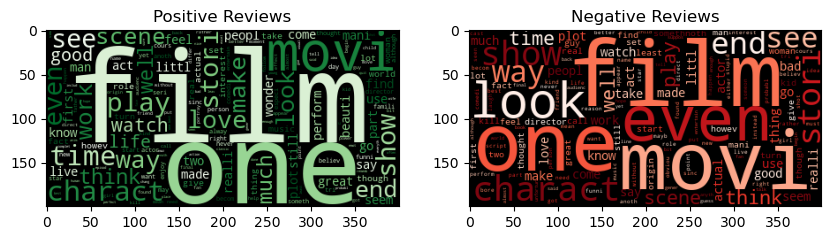

In [29]:
from wordcloud import WordCloud

positive_text = " ".join(mv[mv['sentiment']=='positive']['cleaned_review'])
negative_text = " ".join(mv[mv['sentiment']=='negative']['cleaned_review'])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(WordCloud(colormap='Greens').generate(positive_text))
plt.title("Positive Reviews")

plt.subplot(1,2,2)
plt.imshow(WordCloud(colormap='Reds').generate(negative_text))
plt.title("Negative Reviews")
plt.show()


# Feature Engineering:

In [31]:
def extract_basic_features(df, text_column):
    """Extract basic textual features"""
    df_features = df
    
    # Basic length features
    df_features['char_count'] = df_features[text_column].str.len()
    df_features['word_count'] = df_features[text_column].str.split().str.len()
    df_features['sentence_count'] = df_features[text_column].str.split('[.!?]').str.len()
    df_features['avg_word_length'] = df_features['char_count'] / df_features['word_count']
    df_features['avg_sentence_length'] = df_features['word_count'] / df_features['sentence_count']   
    return df_features

In [ ]:
extract_basic_features(mv, 'review')

In [ ]:
mv

In [ ]:
mv['sentiment_num'] = mv['sentiment'].map({'negative': 0, 'positive': 1})

# List of numeric features
numeric_features = ['char_count','word_count','sentence_count','avg_word_length','avg_sentence_length']

# Compute correlation of sentiment with numeric features
sentiment_corr = mv[numeric_features + ['sentiment_num']].corr()['sentiment_num'].drop('sentiment_num')

print(sentiment_corr)

In [ ]:
corr_values = []
p_values = []

for feature in numeric_features:
    corr, pval = pearsonr(mv[feature], mv['sentiment_num'])
    corr_values.append(corr)
    p_values.append(pval)

corr_pval_df = pd.DataFrame({
    'Feature': numeric_features,
    'Correlation': corr_values,
    'P-value': p_values
}).set_index('Feature')

print(corr_pval_df)
# Plot heatmap
plt.figure(figsize=(8,5))
sns.heatmap(
    corr_pval_df[['Correlation']],  # show correlation values
    annot=corr_pval_df[['Correlation']].map(lambda x: f"{x:.3f}"),  # show p-values as annotations
    fmt='',
    cmap='coolwarm',
    center=0
)
plt.title("Correlation with Sentiment (p-values annotated)")
plt.show()


### All correlations are very weak (close to 0), meaning these numeric features alone don’t strongly predict sentiment.

# Model Development

In [ ]:
numeric_features = mv[['char_count','word_count','sentence_count','avg_word_length','avg_sentence_length']]
text_features = mv['cleaned_review']
y = mv['sentiment']
y = y.map({'negative': 0, 'positive': 1})


X_train_text, X_test_text, y_train, y_test, train_idx, test_idx = train_test_split(
    text_features, y, mv.index, test_size=0.2, random_state=42
)

X_train_num = numeric_features.loc[train_idx]
X_test_num = numeric_features.loc[test_idx]

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train_text.progress_apply(str))
X_test_tfidf = tfidf.transform(X_test_text.progress_apply(str))

# Combine text + numeric features
X_train_combined = hstack([X_train_tfidf, X_train_num.values])
X_test_combined = hstack([X_test_tfidf, X_test_num.values])


# Random Forest with GridSearchCV

rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    rf, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1
)

grid_search.fit(X_train_combined, y_train)

print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

Numeric Feature Importances:
               feature  importance
4  avg_sentence_length    0.003304
3      avg_word_length    0.002875
0           char_count    0.002596
1           word_count    0.002535
2       sentence_count    0.002121


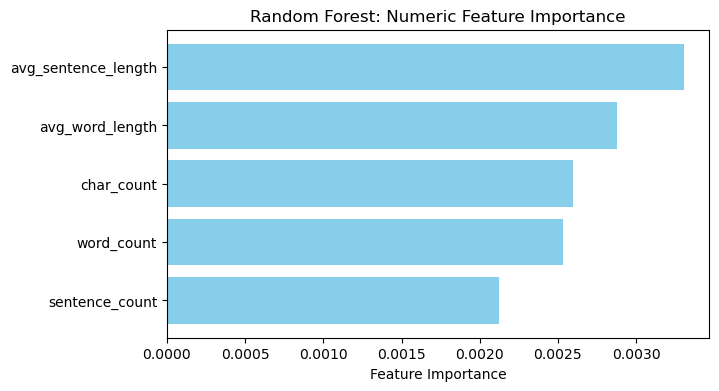

In [289]:
importances = best_rf.feature_importances_

# Numeric features importance (last 5 columns)
numeric_cols = numeric_features.columns.tolist()
numeric_importances = importances[-len(numeric_cols):]

# DataFrame for numeric features
feat_imp_df = pd.DataFrame({
    'feature': numeric_cols,
    'importance': numeric_importances
}).sort_values(by='importance', ascending=False)

print("Numeric Feature Importances:")
print(feat_imp_df)

# Plot numeric feature importance
plt.figure(figsize=(7,4))
plt.barh(feat_imp_df['feature'], feat_imp_df['importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Random Forest: Numeric Feature Importance")
plt.gca().invert_yaxis()
plt.show()

# The small values (0.002–0.003) indicate that text features contribute far more than numeric features.

In [304]:
y_pred = best_rf.predict(X_test_combined)
y_pred_proba = best_rf.predict_proba(X_test_combined)[:, 1]

In [305]:
prec, rec, thres = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (prec * rec) / (prec + rec)
best_threshold = thres[np.argmax(f1_scores)]

print("Best Threshold (max F1):", best_threshold)

# Apply threshold
y_pred_custom = (y_pred_proba >= best_threshold).astype(int)

# Evaluate
print("\nClassification Report:\n", classification_report(y_test, y_pred_custom))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_custom))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

Best Threshold (max F1): 0.4689722222222223

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.80      0.84      4995
           1       0.81      0.90      0.85      4922

    accuracy                           0.85      9917
   macro avg       0.85      0.85      0.85      9917
weighted avg       0.85      0.85      0.85      9917


Confusion Matrix:
 [[3977 1018]
 [ 497 4425]]

ROC-AUC Score: 0.9300431679139521


In [395]:
X = mv['cleaned_review']
y = mv['sentiment']
y = y.map({'negative': False, 'positive': True})


X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X, y, mv.index, test_size=0.2, random_state=42
)

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train.progress_apply(str))
X_test_tfidf = tfidf.transform(X_test.progress_apply(str))


# Random Forest with GridSearchCV

rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    rf, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=2
)

grid_search.fit(X_train_tfidf, y_train)

print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

100%|██████████████████████████████████████████████████████████████████████████| 9917/9917 [00:00<00:00, 185295.34it/s]


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


In [397]:
y_pred = best_rf.predict(X_train_tfidf)

y_pred_proba = best_rf.predict_proba(X_test_tfidf)[:, 1]

In [398]:
prec, rec, thres = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (prec * rec) / (prec + rec)
best_threshold = thres[np.argmax(f1_scores)]

print("Best Threshold (max F1):", best_threshold)

# Apply threshold
y_pred_custom = (y_pred_proba >= best_threshold).astype(int)

# Evaluate
print("\nClassification Report:\n", classification_report(y_test, y_pred_custom))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_custom))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

Best Threshold (max F1): 0.4568888888888889

Classification Report:
               precision    recall  f1-score   support

       False       0.90      0.78      0.84      4995
        True       0.81      0.91      0.86      4922

    accuracy                           0.85      9917
   macro avg       0.85      0.85      0.85      9917
weighted avg       0.85      0.85      0.85      9917


Confusion Matrix:
 [[3915 1080]
 [ 430 4492]]

ROC-AUC Score: 0.9300218951173846


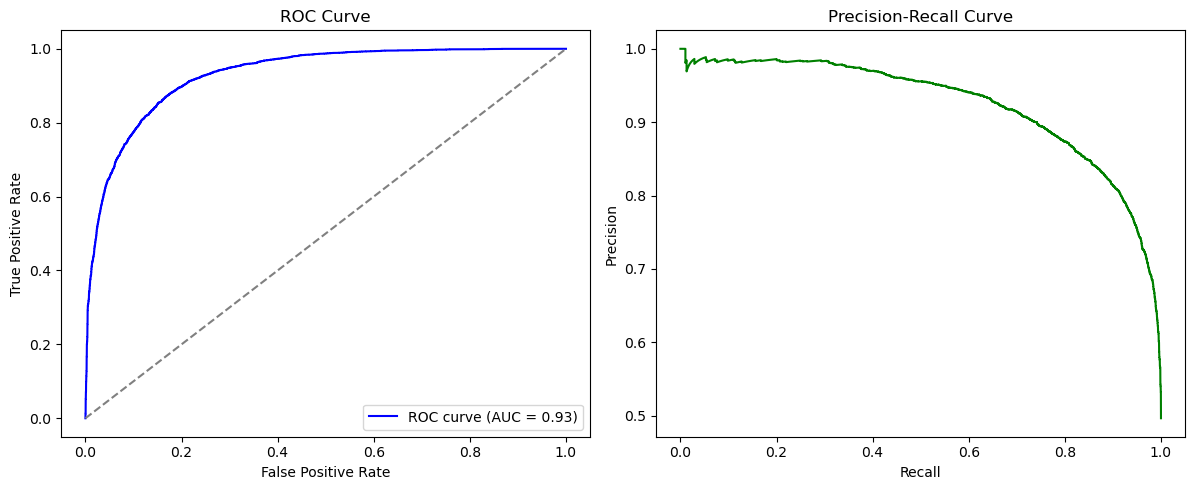

In [399]:
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)

# Plotting
plt.figure(figsize=(18,5))

# ROC Curve
plt.subplot(1,3,1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Precision-Recall Curve
plt.subplot(1,3,2)
plt.plot(recall, precision, color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

# Logistic Regression 

In [56]:
X = mv['cleaned_review']
y = mv['sentiment']
y = y.map({'negative': False, 'positive': True})


X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X, y, mv.index, test_size=0.2, random_state=42
)

# TF-IDF vectorization
tfidf1 = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf1.fit_transform(X_train.progress_apply(str))
X_test_tfidf = tfidf1.transform(X_test.progress_apply(str))



# Initialize model
lr = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')

# Hyperparameter tuning with GridSearchCV
param_grid_lr = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1','l2']}

grid_lr = GridSearchCV(lr, param_grid_lr, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid_lr.fit(X_train_tfidf, y_train)

best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test_tfidf)
y_pred_proba_lr = best_lr.predict_proba(X_test_tfidf)[:, 1]

# Evaluate
print("Logistic Regression Metrics:")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba_lr))


100%|██████████████████████████████████████████████████████████████████████████| 9917/9917 [00:00<00:00, 519235.44it/s]


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Logistic Regression Metrics:
              precision    recall  f1-score   support

       False       0.90      0.88      0.89      4995
        True       0.88      0.90      0.89      4922

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917

Confusion Matrix:
 [[4378  617]
 [ 492 4430]]
ROC-AUC Score: 0.9556492290746658


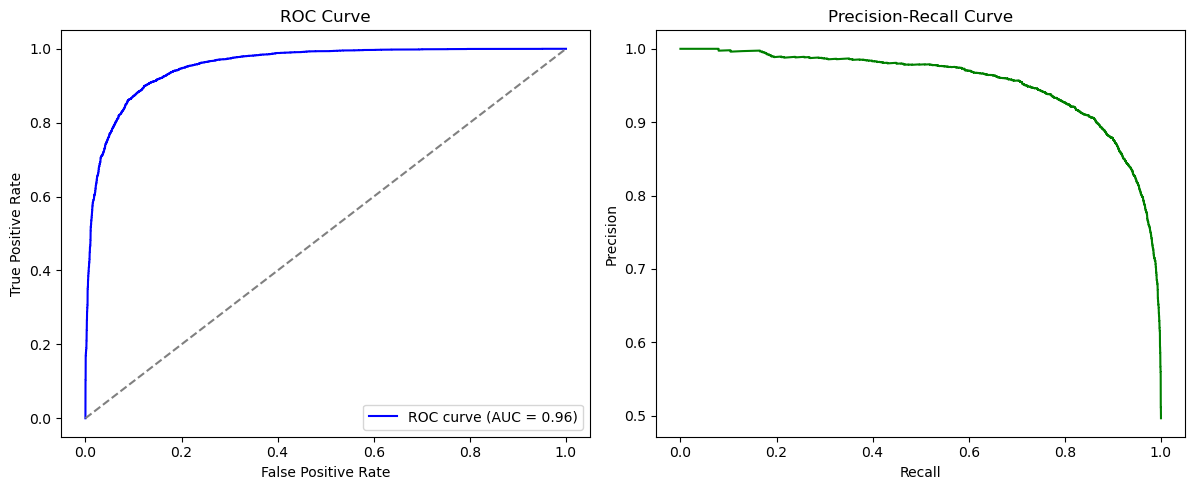

In [50]:
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba_lr)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba_lr)

# Plotting
plt.figure(figsize=(18,5))

# ROC Curve
plt.subplot(1,3,1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Precision-Recall Curve
plt.subplot(1,3,2)
plt.plot(recall, precision, color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.tight_layout()
plt.show()

# Naive Bayes (Multinomial)

In [64]:
nb = MultinomialNB()

# Hyperparameter tuning
param_grid_nb = {'alpha': [0.1, 0.5, 1.0]}

grid_nb = GridSearchCV(nb, param_grid_nb, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid_nb.fit(X_train_tfidf, y_train)

best_nb = grid_nb.best_estimator_
y_pred_nb = best_nb.predict(X_test_tfidf)
y_pred_proba_nb = best_nb.predict_proba(X_test_tfidf)[:, 1]

# Evaluate
print("Naive Bayes Metrics:")
print(classification_report(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba_nb))


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes Metrics:
              precision    recall  f1-score   support

       False       0.87      0.84      0.85      4995
        True       0.84      0.88      0.86      4922

    accuracy                           0.86      9917
   macro avg       0.86      0.86      0.86      9917
weighted avg       0.86      0.86      0.86      9917

Confusion Matrix:
 [[4176  819]
 [ 609 4313]]
ROC-AUC Score: 0.9298618407110888


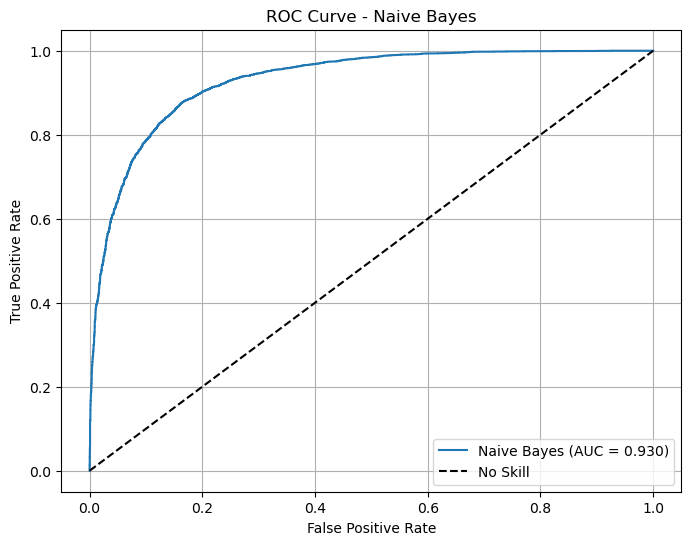

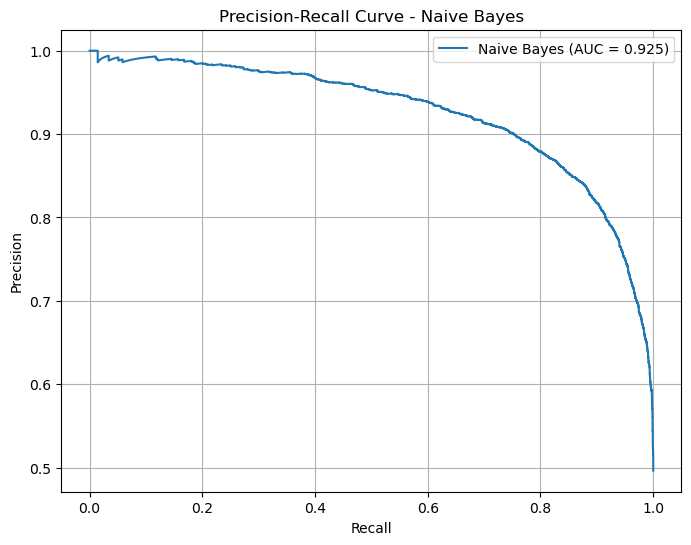

In [66]:
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba_nb)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Naive Bayes (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes')
plt.legend()
plt.grid(True)
plt.show()

# --- Precision-Recall Curve ---
prec, rec, pr_thresholds = precision_recall_curve(y_test, y_pred_proba_nb)
pr_auc = auc(rec, prec)

plt.figure(figsize=(8, 6))
plt.plot(rec, prec, label=f'Naive Bayes (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Naive Bayes')
plt.legend()
plt.grid(True)
plt.show()

# LSTM

In [119]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Features and target
X = mv['cleaned_review'].astype(str)
y = mv['sentiment'].map({'negative': 0, 'positive': 1}).values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [115]:
review_lengths = X_train.str.split().apply(len)
review_lengths.describe()

count    39664.000000
mean       119.995386
std         90.573217
min          1.000000
25%         64.000000
50%         89.000000
75%        146.000000
max       1428.000000
Name: cleaned_review, dtype: float64

In [121]:
max_words = 10000  # top 10k words in vocabulary
max_len = 200      # max length of each review

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to have same length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

In [123]:
embedding_dim = 100

model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [125]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train_pad, y_train, validation_split=0.1, epochs=10, batch_size=64, callbacks=[early_stop], verbose=2)
model.summary() 

Epoch 1/10
558/558 - 121s - 217ms/step - accuracy: 0.8243 - loss: 0.3953 - val_accuracy: 0.8724 - val_loss: 0.3110
Epoch 2/10
558/558 - 95s - 171ms/step - accuracy: 0.9034 - loss: 0.2562 - val_accuracy: 0.8813 - val_loss: 0.3220
Epoch 3/10
558/558 - 96s - 172ms/step - accuracy: 0.9204 - loss: 0.2105 - val_accuracy: 0.8674 - val_loss: 0.3189
Epoch 4/10
558/558 - 99s - 177ms/step - accuracy: 0.9322 - loss: 0.1870 - val_accuracy: 0.8770 - val_loss: 0.3469


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 200, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,253,829 (12.41 MB)

 Trainable params: 1,084,609 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,169,220 (8.27 MB)

In [127]:
# Predict
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob))

310/310 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step
Accuracy: 0.8787939901179792

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.84      0.87      4940
           1       0.85      0.92      0.88      4977

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917


Confusion Matrix:
 [[4135  805]
 [ 397 4580]]
ROC-AUC Score: 0.9445725641595061


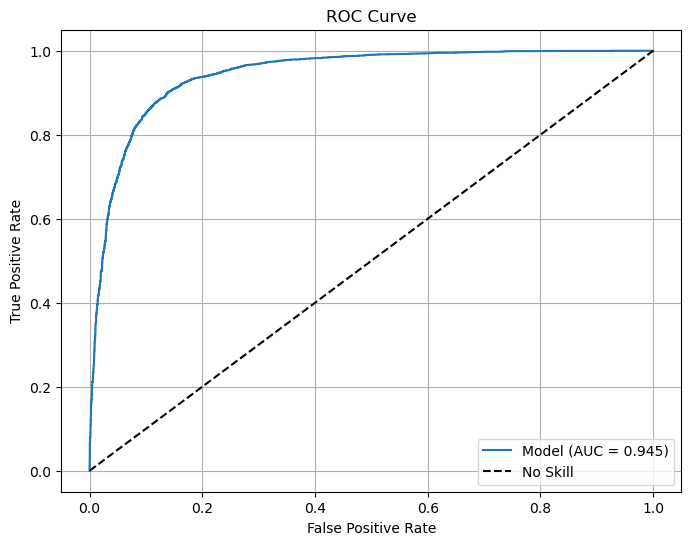

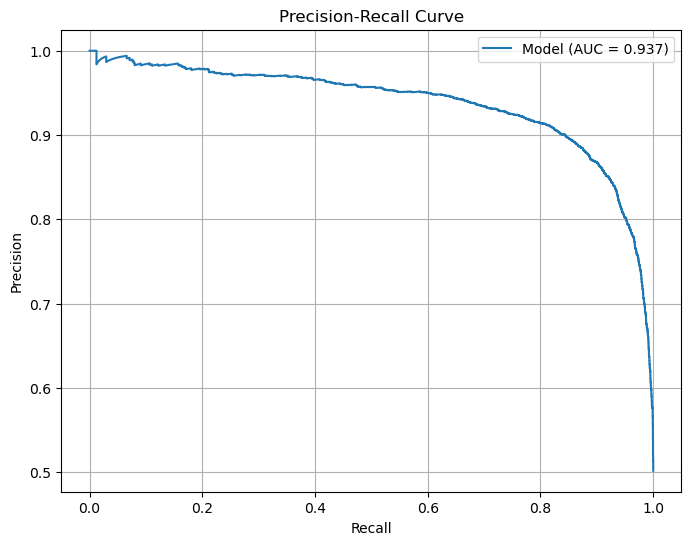

In [129]:
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Model (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# --- Precision-Recall Curve ---
prec, rec, pr_thresholds = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(rec, prec)

plt.figure(figsize=(8, 6))
plt.plot(rec, prec, label=f'Model (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

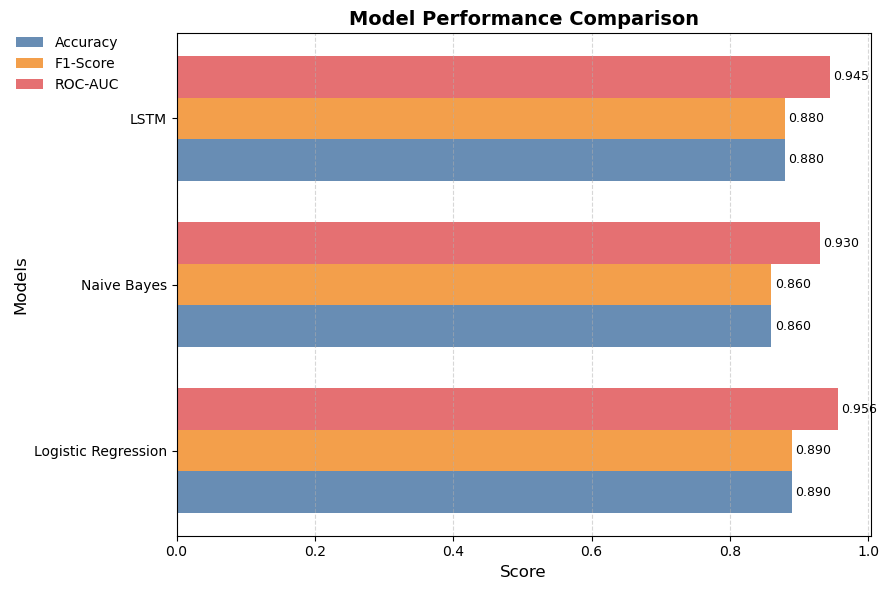

In [153]:
import numpy as np
import matplotlib.pyplot as plt

# Models and metrics
models = ['Logistic Regression', 'Naive Bayes', 'LSTM']
accuracy = [0.89, 0.86, 0.88]
f1 = [0.89, 0.86, 0.88]
roc_auc = [0.956, 0.930, 0.945]

y = np.arange(len(models))
width = 0.25  # thinner bars since we have 3 metrics

fig, ax = plt.subplots(figsize=(9, 6))

# Horizontal bars for each metric
bars1 = ax.barh(y - width, accuracy, width, label='Accuracy', color='#4e79a7', alpha=0.85)
bars2 = ax.barh(y, f1, width, label='F1-Score', color='#f28e2b', alpha=0.85)
bars3 = ax.barh(y + width, roc_auc, width, label='ROC-AUC', color='#e15759', alpha=0.85)

# Labels and title
ax.set_xlabel('Score', fontsize=12)
ax.set_ylabel('Models', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')

ax.set_yticks(y)
ax.set_yticklabels(models)
ax.legend(
    loc='upper left',             # anchor top-left corner of legend box
    bbox_to_anchor=(-0.25, 1.02), # move outside plot (x negative = left)
    fontsize=10,
    frameon=False
)
# Add value labels next to bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        score = bar.get_width()
        ax.text(score + 0.005, bar.get_y() + bar.get_height()/2,
                f'{score:.3f}', ha='left', va='center', fontsize=9)

plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Recomendations: Logistic Regression

**Key Performance Metrics:**
- Accuracy: 89%
- F1-Score: 0.89 (both classes)
- ROC-AUC Score: 0.956 (highest among all models)
- Precision/Recall Balance: Excellent (0.88-0.90 across classes)


video link: https://drive.google.com/file/d/1OOZmO7xS4FlU_kfawVuuRAoRH2kKkwaP/view?usp=sharing

In [70]:
def predict_sentiment(review_text, model, vectorizer, preprocessor):
    """
    Predict sentiment of a new review using the trained Logistic Regression model.
    """
    # Preprocess
    cleaned = preprocessor.preprocess_pipeline(review_text)
    
    # Transform
    features = tfidf1.transform([cleaned])
    
    # Predict
    pred = model.predict(features)[0]
    proba = model.predict_proba(features)[0]
    
    sentiment = "positive" if pred == 1 else "negative"
    confidence = float(proba[1] if pred == 1 else proba[0])
    
    return sentiment, confidence

# Usage:
new_review = "The movie was boring and poorly acted."
sentiment, confidence = predict_sentiment(new_review, best_lr, tfidf, TextPreprocessor())
print(f"Sentiment: {sentiment}, Confidence: {confidence:.2f}")

Sentiment: negative, Confidence: 1.00
